Мы собрали логи вида: ID пользователя, время, № турникета. Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить “таблетку”. Все это фиксируется - кто, в какую дату, в какое время, какой турникет.

Есть данные за один год, но в новом году что-то случилось и ID пользователей перемешались. Нужно восстановить ID пользователей в новом году по следу: по записям времени и № турникета для пользователя с неправильным ID.

Сможем ли мы понять кому конкретно принадлежит след прохода через турникеты по паттернам в поведении?

«8 утра понедельник, турникет 4? Директор.» «11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.»

Какие есть паттерны в настоящих данных?

В тестовой выборке ID посетителей перемешаны.

Ваша задача - составить таблицу вида:

lost_id	preds
12	49
55	12
49	55
23	-999
17	15
...	…
где lost_id - неправильный ID, preds - колонка с предсказанным правильным id. Таблицу нужно запомнить как csv и потом заархивировать в zip архив (см. пример файла ответа в секции "Данные и Оценка"). -999 – ID нового посетителя, которого раньше не было.

Каждому ID сопоставлен вес, который зависит от того, насколько его трудно предсказать. Оценка - это взвешенная сумма правильных ответов. Чем сложнее вы отгадали ID, тем больше баллов.

Про работу платформы: при отправке решения смотрите логи. Если падает с ошибкой - значит у вас неправильно подготовлен файл для отправки. Требуется zip файл с answer.csv, названиями колонок lost_ id (кол-во строк = 34) и preds (в этой колонке предсказанный user_ id).

In [1]:
import datetime

import pandas as pd
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version

from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
train_df = pd.read_csv('train.csv', index_col=0, parse_dates=['ts'])

In [3]:
train_df

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
5,18,2022-07-29 09:10:34,10
...,...,...,...
37512,6,2022-12-31 17:21:19,10
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6


In [4]:
test_df = pd.read_csv('test.csv', index_col=0, parse_dates=['ts'])

In [5]:
test_df

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


# Разведка данных

Проверим есть ли Nan значения в тренировачном и тестовом наборе

In [6]:
print('Check NaNs:', train_df.isnull().values.any(), test_df.isnull().values.any())

Check NaNs: False False


Посмотрим на минимальные и максимальные даты проходов через турникеты, по максимальным данным можно предположить что если человек "пропал" более чем на месяц, тогда скорее всего он ушел из компании, и можно его дропнуть из модели далее

In [7]:
pd.pivot_table(train_df, index=['user_id'], aggfunc=['min', 'max']).sort_values(('max', 'ts'), ascending=True)

min                         max                    
        gate_id                  ts gate_id                  ts
user_id                                                        
4             8 2022-08-09 10:09:08       8 2022-08-09 10:09:08
52            4 2022-08-10 10:58:42       7 2022-08-10 13:33:07
20            3 2022-07-29 11:14:48      11 2022-08-17 17:23:43
42            3 2022-09-02 19:14:17      11 2022-10-07 16:35:30
40            3 2022-08-01 16:51:08      11 2022-10-14 17:06:43
28            3 2022-08-18 09:24:55      11 2022-10-20 10:40:38
45            3 2022-08-03 18:20:09      11 2022-10-21 19:44:31
7             3 2022-08-22 09:35:50      11 2022-10-24 11:09:17
8             3 2022-08-09 11:58:08      11 2022-11-03 12:15:29
38            3 2022-11-01 13:16:48      11 2022-11-03 15:19:03
31            3 2022-07-29 10:41:50      11 2022-11-17 14:33:22
57           -1 2022-08-09 10:07:15      11 2022-11-18 21:32:17
27            3 2022-07-29 19:39:57      13 2022-11-22 11:17:21
5             4 2022-10-26 10:58:20      10 2022-11-30 14:22:49
34            3 2022-08-03 08:59:18      11 2022-12-07 16:13:42
10            3 2022-11-30 15:18:00      11 2022-12-07 19:39:48
22            3 2022-08-03 10:32:00      11 2022-12-07 19:41:13
9             3 2022-08-01 11:15:54      11 2022-12-12 17:42:51
51            3 2022-12-13 13:30:11       9 2022-12-16 13:56:08
36           -1 2022-08-31 13:27:04      11 2022-12-16 17:27:18
41            3 2022-11-22 11:17:37      13 2022-12-20 18:07:37
53            3 2022-07-29 11:07:07      13 2022-12-23 13:00:09
18            3 2022-07-29 09:08:54      13 2022-12-23 13:02:28
48            3 2022-08-01 11:18:21      11 2022-12-23 13:04:38
47            3 2022-07-29 10:25:12      13 2022-12-23 13:05:26
26           -1 2022-07-29 10:46:23      15 2022-12-23 20:18:40
30            4 2022-12-16 14:03:16      11 2022-12-27 19:30:07
49            3 2022-07-29 11:06:15      15 2022-12-28 14:18:10
44            4 2022-12-28 14:22:19       5 2022-12-28 14:22:39
21            5 2022-12-16 14:03:08      16 2022-12-28 14:49:54
25            0 2022-08-01 09:08:00      16 2022-12-28 18:15:36
56           -1 2022-08-01 19:24:18      16 2022-12-28 18:34:48
43            3 2022-11-29 14:36:24      11 2022-12-29 19:43:02
23           -1 2022-08-03 18:45:22      12 2022-12-30 14:36:26
24            3 2022-07-29 10:12:52      15 2022-12-30 16:42:24
46           -1 2022-07-29 12:45:27      13 2022-12-30 16:46:00
19            3 2022-07-29 11:39:16      13 2022-12-30 17:00:49
2             3 2022-12-28 14:22:24      11 2022-12-30 17:55:00
50            3 2022-07-29 11:02:48      11 2022-12-30 18:14:29
3             3 2022-07-29 09:40:40      11 2022-12-30 18:47:10
14            3 2022-09-19 16:33:06      11 2022-12-30 19:02:47
55           -1 2022-07-29 10:09:23      15 2022-12-30 19:07:39
35            3 2022-10-07 15:36:58      11 2022-12-30 19:09:37
12            3 2022-07-29 12:29:28      14 2022-12-30 19:09:41
0             3 2022-07-29 10:30:17      11 2022-12-30 19:09:43
1            -1 2022-07-29 09:33:16      15 2022-12-30 19:14:34
17            3 2022-10-07 15:37:04      11 2022-12-30 19:15:34
11           -1 2022-08-01 10:14:59      13 2022-12-30 19:15:34
33            3 2022-07-29 10:29:44      11 2022-12-30 19:21:17
15            3 2022-08-01 10:43:34      11 2022-12-30 19:31:24
37            3 2022-07-29 10:42:04      13 2022-12-30 19:32:08
32            3 2022-08-15 11:28:18      11 2022-12-30 19:33:04
54            3 2022-07-29 11:21:42      11 2022-12-30 19:47:21
39            3 2022-07-29 10:20:52      11 2022-12-30 20:35:00
29           -1 2022-07-29 09:53:44      11 2022-12-30 20:35:06
6            -1 2022-07-29 09:53:22      13 2022-12-31 20:39:31

Тестовые данные тоже посморим за компанию, возможно люди которые вышли в конце января, возможно это новые сотрудники

In [8]:
pd.pivot_table(test_df, index=['lost_id'], aggfunc=['min', 'max']).sort_values(('min', 'ts'), ascending=True)

min                         max                    
        gate_id                  ts gate_id                  ts
lost_id                                                        
1             4 2023-01-03 08:21:00      14 2023-02-23 17:57:25
19            3 2023-01-03 08:32:49      15 2023-02-20 08:24:51
54            3 2023-01-03 09:21:29      13 2023-02-03 14:50:18
11            3 2023-01-03 09:24:23      11 2023-02-24 11:21:18
32            3 2023-01-03 09:56:54      11 2023-02-03 20:22:35
17            3 2023-01-03 10:27:23      11 2023-02-01 13:37:16
53            3 2023-01-03 10:30:08      11 2023-02-19 15:29:18
3             3 2023-01-03 10:38:20      13 2023-01-30 19:22:49
37           -1 2023-01-03 10:44:17      13 2023-02-23 21:43:14
55            3 2023-01-03 10:50:00      13 2023-02-15 22:22:30
12            3 2023-01-03 10:57:38      11 2023-02-22 18:11:38
35            3 2023-01-03 11:17:44      11 2023-01-27 12:37:40
9             3 2023-01-03 11:21:19      11 2023-02-03 19:40:07
15            3 2023-01-03 11:23:37      11 2023-02-24 19:44:09
49            3 2023-01-03 11:38:58      11 2023-02-17 20:20:43
23            3 2023-01-03 12:58:57      11 2023-01-04 17:27:26
34            3 2023-01-03 12:59:35      11 2023-02-02 18:06:13
0             3 2023-01-03 13:42:04      11 2023-01-27 12:47:23
25            4 2023-01-03 15:42:45      11 2023-01-03 16:59:20
33            2 2023-01-03 16:56:15      11 2023-02-24 14:03:47
47            3 2023-01-04 09:30:35      15 2023-02-17 17:27:38
26            4 2023-01-04 11:07:00      15 2023-02-07 19:05:37
6             3 2023-01-04 11:09:55      15 2023-02-06 18:59:11
18            3 2023-01-05 11:16:42      13 2023-02-17 16:15:03
50            3 2023-01-05 11:43:19      11 2023-02-19 13:04:29
14            3 2023-01-06 10:52:24      11 2023-01-19 14:52:11
27            3 2023-01-06 15:03:01      11 2023-02-07 16:56:26
29            3 2023-01-09 10:43:49      11 2023-01-27 21:15:39
39            3 2023-01-09 10:53:52      11 2023-02-17 13:54:13
48            3 2023-01-09 11:41:32      11 2023-01-24 17:55:51
46            4 2023-01-12 07:41:59      11 2023-01-26 20:13:47
42            3 2023-01-27 12:37:16      11 2023-02-19 14:58:01
57            1 2023-01-27 12:37:43      11 2023-02-18 16:51:43
24            1 2023-01-31 10:51:08      11 2023-02-20 14:21:48

Изучим какие есть гейты

In [9]:
sorted(list(train_df['gate_id'].unique()))

[-1, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [10]:
sorted(list(test_df['gate_id'].unique()))

[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Найдем каких нет в тесте и в трейне, потом дропнем

In [11]:
no_found_in_test = set(train_df['gate_id'].unique()) - set(test_df['gate_id'].unique())
no_found_in_test

{0, 16}

In [12]:
no_found_in_train = set(test_df['gate_id'].unique()) - set(train_df['gate_id'].unique())
no_found_in_train

{2}

In [13]:
train_df.groupby('gate_id')['gate_id'].count()

gate_id
-1       25
 0        2
 1        5
 3     5220
 4     7980
 5     4554
 6     1741
 7     3026
 8       24
 9     1729
 10    4767
 11    4090
 12     619
 13    1087
 14       1
 15     298
 16       4
Name: gate_id, dtype: int64

In [14]:
test_df.groupby('gate_id')['gate_id'].count()

gate_id
-1        1
 1        2
 2        4
 3      893
 4     1431
 5      853
 6      282
 7      540
 8       10
 9      394
 10     915
 11     762
 12     120
 13     310
 14       1
 15     102
Name: gate_id, dtype: int64

Посмотрим распределение гейтов до дропа "дубликатов", не сильно похожи

<Axes: >

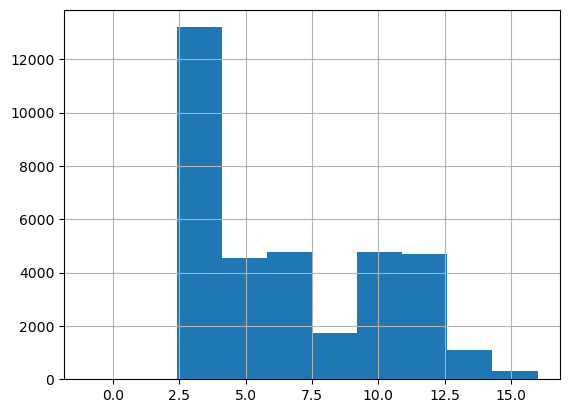

In [15]:
train_df['gate_id'].hist()

<Axes: >

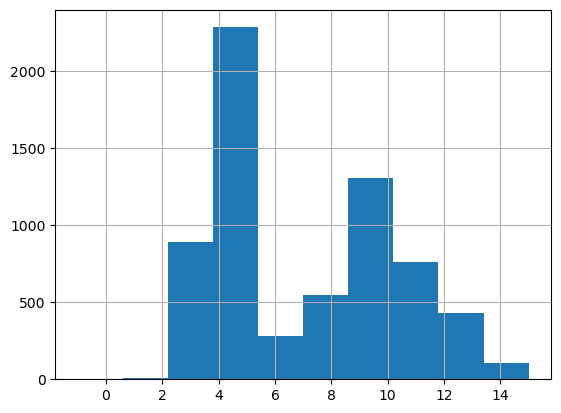

In [16]:
test_df['gate_id'].hist()

-1 и 0 подозрительный гейт возможно тестовый, изучим сколько сотрудников под ними

In [17]:
train_df[train_df['gate_id'] == 0]

,user_id,ts,gate_id
12652,25,2022-09-06 11:16:28,0
12653,25,2022-09-06 11:16:36,0


In [18]:
test_df[test_df['gate_id'] == 0]

,ts,gate_id,lost_id


In [19]:
train_df[train_df['gate_id'] == -1]

,user_id,ts,gate_id
329,46,2022-07-29 15:40:13,-1
331,46,2022-07-29 15:40:16,-1
333,46,2022-07-29 15:51:47,-1
8162,46,2022-08-22 15:29:12,-1
11858,56,2022-09-02 15:29:33,-1
11860,56,2022-09-02 15:29:42,-1
11862,56,2022-09-02 15:29:58,-1
11929,36,2022-09-02 16:45:58,-1
11931,36,2022-09-02 16:46:02,-1
12741,6,2022-09-06 14:46:12,-1


In [20]:
test_df[test_df['gate_id'] == -1]

,ts,gate_id,lost_id
43341,2023-01-31 15:51:37,-1,37


Очень мало под ним проходили, проверялось с ними и без, с ним точность не возрастает, буду дропать

# Feature engineering

Дропнем гейт странные гейты

In [21]:
train_df.drop(train_df[train_df['gate_id'] == -1].index, inplace=True) 
train_df.drop(train_df[train_df['gate_id'].isin(no_found_in_test)].index, inplace=True) 
test_df.drop(test_df[test_df['gate_id'] == -1].index, inplace=True) 
test_df.drop(test_df[test_df['gate_id'].isin(no_found_in_train)].index, inplace=True) 

Удалим тех кого нет больше месяца

In [22]:
maybe_left = train_df.groupby('user_id').agg({'ts': 'max'})['ts'] < '2022-12-01'
ids = maybe_left[maybe_left].index
ids

Index([4, 5, 7, 8, 20, 27, 28, 31, 38, 40, 42, 45, 52, 57], dtype='int64', name='user_id')

In [23]:
train_df.drop(train_df[train_df['user_id'].isin(ids)].index, inplace=True)

In [24]:
train_df

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
5,18,2022-07-29 09:10:34,10
...,...,...,...
37512,6,2022-12-31 17:21:19,10
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6


Также в данных были очень близкие по времени и гейтам записи возможно приложили 2 и более раз или дребезг контактов, проверим что разница по времени "не большая" и тот же гейт и дропнем

In [25]:
def drop_gate_duplicates(df, col):
    enter_diff_train_groups = df.groupby([df['ts'].dt.floor('d'), col])
    diff = enter_diff_train_groups['ts'].diff().dt.total_seconds().fillna(0)
    print(diff.agg({'min', 'max', 'mean', 'median', 'std'}))
    treshold = diff.quantile(.4)
    print('Quantile .1:', treshold)
    diff_gate = enter_diff_train_groups['gate_id'].diff().fillna(-1)
    return df.drop(df[(diff_gate == 0) & (diff < treshold)].index)

In [26]:
totas_seconds = train_df.groupby([train_df['ts'].dt.floor('d'), 'user_id'])['ts'].diff().dt.total_seconds().dropna()

<Axes: >

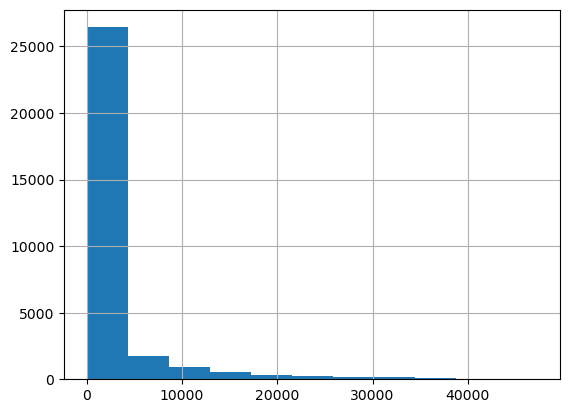

In [27]:
totas_seconds.hist(bins=11)

In [28]:
train_df = drop_gate_duplicates(train_df, 'user_id')

min           0.000000
mean       1932.990163
median       22.000000
max       47310.000000
std        5364.847759
Name: ts, dtype: float64
Quantile .1: 12.0


In [29]:
train_df

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
5,18,2022-07-29 09:10:34,10
6,18,2022-07-29 09:32:47,11
...,...,...,...
37510,6,2022-12-31 17:20:57,5
37512,6,2022-12-31 17:21:19,10
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6


In [30]:
test_df

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


In [31]:
test_df = drop_gate_duplicates(test_df, 'lost_id')

min           0.000000
mean       2015.001663
median       20.000000
max       53197.000000
std        5960.979818
Name: ts, dtype: float64
Quantile .1: 10.0


После удаления дубликатов стали вполне "Похожи"

<Axes: >

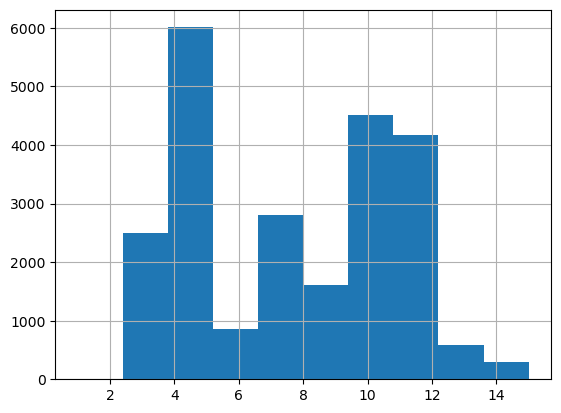

In [32]:
train_df['gate_id'].hist()

<Axes: >

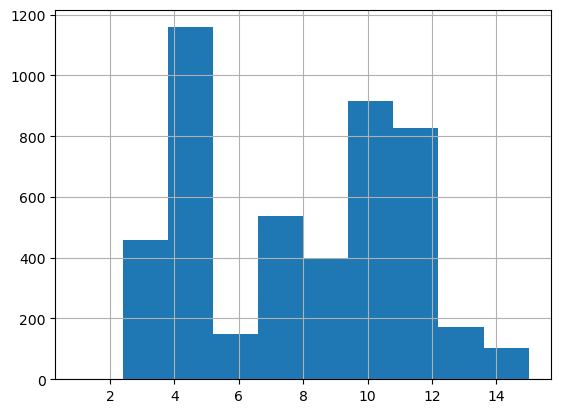

In [33]:
test_df['gate_id'].hist()

In [34]:
test_df

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
37524,2023-01-03 08:36:02,9,19
...,...,...,...
44636,2023-02-24 17:02:27,11,15
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15


Обогатим данные чем сможем: у нас есть гейты и время его прохода, сгруппируем по дням и сотруднику возмем время и проверим что за день недели, время первого прохода и последнего, продолжительность работы, транспонируем номера гейтов в столбцы чтобы получить паттерно проходов и разницы времени проходов, время закодируем в синус и косинус чтобы модель могла легче находить разницу между ними согласно статьям и в конце удалим первый столбец у них для исключения мультиколлениарности, потом раскидаем по столбцам и сравняем размеры с заполением нулями типа dummies. Также удалим паттерны гейтов длинее 20, потому-что они не оказывают влияния на точность.

In [35]:
def data_enrichment(df, group_by_col, pattern_padding = None):
    gates_in_day_pattern = pd.DataFrame()
    groups = df.groupby([group_by_col, df['ts'].dt.floor('d')])
    
    for _, group in groups:
        ts = group['ts'].iloc[0]
        ts_last_gate = group['ts'].iloc[-1]
        worktime = ts_last_gate - ts
        diff = group['ts'].diff()

        if (len(group['gate_id'].values) > 20): # pass anomaly long patterns
            continue
            
        gates_in_day_pattern = pd.concat([gates_in_day_pattern, pd.DataFrame({
            group_by_col: group[group_by_col].values[0],
            'is_month_start': int(ts.is_month_start),
            'is_month_end': int(ts.is_month_end),
            'is_bussines_day_start': int(ts.dayofweek == 0),
            'is_bussines_day_end': int(ts.dayofweek == 4),
            'is_bussines_day': int(0 <= ts.dayofweek <= 4),
            'is_weekend': int(ts.dayofweek > 4),
            'worktime_hour_sin': np.sin((worktime.seconds / 3600 * np.pi * 2) / 24),
            'worktime_hour_cos': np.cos((worktime.seconds / 3600 * np.pi * 2) / 24),
            'worktime_min_sin': np.sin((worktime.seconds % 3600 / 60 * np.pi * 2) / 60),
            'worktime_min_cos': np.cos((worktime.seconds % 3600 / 60 * np.pi * 2) / 60),
            'first_enter_hour_sin': np.sin((ts.hour * np.pi * 2) / 24),
            'first_enter_hour_cos': np.cos((ts.hour * np.pi * 2) / 24),
            'first_enter_min_sin': np.sin((ts.minute * np.pi * 2) / 60),
            'first_enter_min_cos': np.cos((ts.minute * np.pi * 2) / 60),
            'exit_hour_sin': np.sin((ts_last_gate.hour * np.pi * 2) / 24),
            'exit_hour_cos': np.cos((ts_last_gate.hour * np.pi * 2) / 24),
            'exit_min_sin': np.sin((ts_last_gate.minute * np.pi * 2) / 60),
            'exit_min_cos': np.cos((ts_last_gate.minute * np.pi * 2) / 60),
            'day_sin': np.sin((ts.day * np.pi * 2) / 31),
            'day_cos': np.cos((ts.day * np.pi * 2) / 31),
            'dayofweek_sin': np.sin((ts.dayofweek * np.pi * 2) / 6),
            'dayofweek_cos': np.cos((ts.dayofweek * np.pi * 2) / 6),
            'month_sin': np.sin((ts.month * np.pi * 2) / 12),
            'month_cos': np.cos((ts.month * np.pi * 2) / 12),
            'gates_pattern': [group['gate_id'].values],
            'gates_timing': [(group['ts'].diff().dt.total_seconds()).fillna(0).astype('int').values]
    })], ignore_index=True)

    if pattern_padding == None:
        pattern_padding = gates_in_day_pattern['gates_pattern'].apply(lambda x: x.size).max()
    
    gates_in_day_pattern['gates_pattern'] = gates_in_day_pattern['gates_pattern'].apply(lambda x: np.pad(x, (0, pattern_padding - x.size), mode='constant'))
    
    gates_in_day_pattern['gates_timing_hours_sin'] = gates_in_day_pattern['gates_timing'] \
                                                    .apply(lambda x: np.pad(np.sin((x // 3600 * np.pi * 2) / 24), (0, pattern_padding - x.size), mode='constant'))
    gates_in_day_pattern['gates_timing_hours_cos'] = gates_in_day_pattern['gates_timing'] \
                                                    .apply(lambda x: np.pad(np.cos((x // 3600 * np.pi * 2) / 24), (0, pattern_padding - x.size), mode='constant'))
    
    gates_in_day_pattern['gates_timing_minutes_sin'] = gates_in_day_pattern['gates_timing'] \
                                                    .apply(lambda x: np.pad(np.sin((x % 3600 // 60 * np.pi * 2) / 60), (0, pattern_padding - x.size), mode='constant'))
    gates_in_day_pattern['gates_timing_minutes_cos'] = gates_in_day_pattern['gates_timing'] \
                                                    .apply(lambda x: np.pad(np.cos((x % 3600 // 60 * np.pi * 2) / 60), (0, pattern_padding - x.size), mode='constant'))
    
    gates_in_day_pattern['gates_timing_seconds_sin'] = gates_in_day_pattern['gates_timing'] \
                                                    .apply(lambda x: np.pad(np.sin((x % 3600 % 60 * np.pi * 2) / 60), (0, pattern_padding - x.size), mode='constant'))
    gates_in_day_pattern['gates_timing_seconds_cos'] = gates_in_day_pattern['gates_timing'] \
                                                    .apply(lambda x: np.pad(np.cos((x % 3600 % 60 * np.pi * 2) / 60), (0, pattern_padding - x.size), mode='constant'))


    gates = range(pattern_padding)
    list_gate_vars = ['gate_' + str(i) for i in gates]
    gates_in_day_pattern[list_gate_vars] = pd.DataFrame(gates_in_day_pattern['gates_pattern'].to_list())

    main_enterance = gates_in_day_pattern['gate_0'].mode().iloc[0]
    gates_in_day_pattern['enter_to_main_enterance'] = (gates_in_day_pattern['gate_0'] == main_enterance).astype('int8')

    list_timing_hours_sin_vars = ['gates_timing_hours_sin_' + str(i) for i in gates]
    list_timing_hours_cos_vars = ['gates_timing_hours_cos_' + str(i) for i in gates]
    gates_in_day_pattern[list_timing_hours_sin_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_hours_sin'].to_list())
    gates_in_day_pattern[list_timing_hours_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_hours_cos'].to_list())

    list_timing_minutes_sin_vars = ['gates_timing_minutes_sin_' + str(i) for i in gates]
    list_timing_minutes_cos_vars = ['gates_timing_minutes_cos_' + str(i) for i in gates]
    gates_in_day_pattern[list_timing_minutes_sin_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_minutes_sin'].to_list())
    gates_in_day_pattern[list_timing_minutes_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_minutes_cos'].to_list())

    list_timing_seconds_sin_vars = ['gates_timing_seconds_sin_' + str(i) for i in gates]
    list_timing_seconds_cos_vars = ['gates_timing_seconds_cos_' + str(i) for i in gates]
    gates_in_day_pattern[list_timing_seconds_sin_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_seconds_sin'].to_list())
    gates_in_day_pattern[list_timing_seconds_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_seconds_cos'].to_list())

    
    gates_in_day_pattern.drop(columns=['gates_pattern', 'gates_timing', 
                                        'gates_timing_hours_sin', 'gates_timing_hours_cos',
                                        'gates_timing_minutes_sin', 'gates_timing_minutes_cos',
                                        'gates_timing_seconds_sin', 'gates_timing_seconds_cos',
                                        'gates_timing_hours_sin_0', 'gates_timing_hours_cos_0',
                                        'gates_timing_minutes_sin_0', 'gates_timing_minutes_cos_0',
                                        'gates_timing_seconds_sin_0', 'gates_timing_seconds_cos_0',
                                      ] , axis=1, inplace=True)

    

    return pattern_padding, gates_in_day_pattern


In [36]:
pattern_padding, train_gates_in_day_pattern = data_enrichment(train_df, 'user_id');

C:\Users\Developer\AppData\Local\Temp\ipykernel_10964\3361235344.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gates_in_day_pattern[list_timing_minutes_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_minutes_cos'].to_list())
C:\Users\Developer\AppData\Local\Temp\ipykernel_10964\3361235344.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gates_in_day_pattern[list_timing_minutes_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_minutes_cos'].to_list())
C:\Users\Developer\AppData\Local\Temp\ipykerne

In [37]:
train_gates_in_day_pattern

,user_id,is_month_start,is_month_end,is_bussines_day_start,is_bussines_day_end,is_bussines_day,is_weekend,worktime_hour_sin,worktime_hour_cos,worktime_min_sin,worktime_min_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_min_sin,first_enter_min_cos,exit_hour_sin,exit_hour_cos,exit_min_sin,exit_min_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16,gate_17,gate_18,gate_19,enter_to_main_enterance,gates_timing_hours_sin_1,gates_timing_hours_sin_2,gates_timing_hours_sin_3,gates_timing_hours_sin_4,gates_timing_hours_sin_5,gates_timing_hours_sin_6,gates_timing_hours_sin_7,gates_timing_hours_sin_8,gates_timing_hours_sin_9,gates_timing_hours_sin_10,gates_timing_hours_sin_11,gates_timing_hours_sin_12,gates_timing_hours_sin_13,gates_timing_hours_sin_14,gates_timing_hours_sin_15,gates_timing_hours_sin_16,gates_timing_hours_sin_17,gates_timing_hours_sin_18,gates_timing_hours_sin_19,gates_timing_hours_cos_1,gates_timing_hours_cos_2,gates_timing_hours_cos_3,gates_timing_hours_cos_4,gates_timing_hours_cos_5,gates_timing_hours_cos_6,gates_timing_hours_cos_7,gates_timing_hours_cos_8,gates_timing_hours_cos_9,gates_timing_hours_cos_10,gates_timing_hours_cos_11,gates_timing_hours_cos_12,gates_timing_hours_cos_13,gates_timing_hours_cos_14,gates_timing_hours_cos_15,gates_timing_hours_cos_16,gates_timing_hours_cos_17,gates_timing_hours_cos_18,gates_timing_hours_cos_19,gates_timing_minutes_sin_1,gates_timing_minutes_sin_2,gates_timing_minutes_sin_3,gates_timing_minutes_sin_4,gates_timing_minutes_sin_5,gates_timing_minutes_sin_6,gates_timing_minutes_sin_7,gates_timing_minutes_sin_8,gates_timing_minutes_sin_9,gates_timing_minutes_sin_10,gates_timing_minutes_sin_11,gates_timing_minutes_sin_12,gates_timing_minutes_sin_13,gates_timing_minutes_sin_14,gates_timing_minutes_sin_15,gates_timing_minutes_sin_16,gates_timing_minutes_sin_17,gates_timing_minutes_sin_18,gates_timing_minutes_sin_19,gates_timing_minutes_cos_1,gates_timing_minutes_cos_2,gates_timing_minutes_cos_3,gates_timing_minutes_cos_4,gates_timing_minutes_cos_5,gates_timing_minutes_cos_6,gates_timing_minutes_cos_7,gates_timing_minutes_cos_8,gates_timing_minutes_cos_9,gates_timing_minutes_cos_10,gates_timing_minutes_cos_11,gates_timing_minutes_cos_12,gates_timing_minutes_cos_13,gates_timing_minutes_cos_14,gates_timing_minutes_cos_15,gates_timing_minutes_cos_16,gates_timing_minutes_cos_17,gates_timing_minutes_cos_18,gates_timing_minutes_cos_19,gates_timing_seconds_sin_1,gates_timing_seconds_sin_2,gates_timing_seconds_sin_3,gates_timing_seconds_sin_4,gates_timing_seconds_sin_5,gates_timing_seconds_sin_6,gates_timing_seconds_sin_7,gates_timing_seconds_sin_8,gates_timing_seconds_sin_9,gates_timing_seconds_sin_10,gates_timing_seconds_sin_11,gates_timing_seconds_sin_12,gates_timing_seconds_sin_13,gates_timing_seconds_sin_14,gates_timing_seconds_sin_15,gates_timing_seconds_sin_16,gates_timing_seconds_sin_17,gates_timing_seconds_sin_18,gates_timing_seconds_sin_19,gates_timing_seconds_cos_1,gates_timing_seconds_cos_2,gates_timing_seconds_cos_3,gates_timing_seconds_cos_4,gates_timing_seconds_cos_5,gates_timing_seconds_cos_6,gates_timing_seconds_cos_7,gates_timing_seconds_cos_8,gates_timing_seconds_cos_9,gates_timing_seconds_cos_10,gates_timing_seconds_cos_11,gates_timing_seconds_cos_12,gates_timing_seconds_cos_13,gates_timing_seconds_cos_14,gates_timing_seconds_cos_15,gates_timing_seconds_cos_16,gates_timing_seconds_cos_17,gates_timing_seconds_cos_18,gates_timing_seconds_cos_19
0,0,0,0,0,1,1,0,0.829038,-0.559193,0.994522,-0.104528,0.500000,-8.660254e-01,5.665539e-16,-1.000000,-1.000000,-1.836970e-16,-0.994522,0.104528,-0.394356,0.918958,-8.660254e-01,-0.5,-5.000000e-01,-0.866025,3,11,6,7,3,10,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,0.000000,0.258819,0.0,0.000000,0.866025,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,1.000000,0.965926,1.0,1

In [38]:
_, test_gates_in_day_pattern = data_enrichment(test_df, 'lost_id', pattern_padding)

C:\Users\Developer\AppData\Local\Temp\ipykernel_10964\3361235344.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gates_in_day_pattern[list_timing_minutes_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_minutes_cos'].to_list())
C:\Users\Developer\AppData\Local\Temp\ipykernel_10964\3361235344.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gates_in_day_pattern[list_timing_minutes_cos_vars] = pd.DataFrame(gates_in_day_pattern['gates_timing_minutes_cos'].to_list())
C:\Users\Developer\AppData\Local\Temp\ipykerne

In [39]:
test_gates_in_day_pattern

,lost_id,is_month_start,is_month_end,is_bussines_day_start,is_bussines_day_end,is_bussines_day,is_weekend,worktime_hour_sin,worktime_hour_cos,worktime_min_sin,worktime_min_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_min_sin,first_enter_min_cos,exit_hour_sin,exit_hour_cos,exit_min_sin,exit_min_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16,gate_17,gate_18,gate_19,enter_to_main_enterance,gates_timing_hours_sin_1,gates_timing_hours_sin_2,gates_timing_hours_sin_3,gates_timing_hours_sin_4,gates_timing_hours_sin_5,gates_timing_hours_sin_6,gates_timing_hours_sin_7,gates_timing_hours_sin_8,gates_timing_hours_sin_9,gates_timing_hours_sin_10,gates_timing_hours_sin_11,gates_timing_hours_sin_12,gates_timing_hours_sin_13,gates_timing_hours_sin_14,gates_timing_hours_sin_15,gates_timing_hours_sin_16,gates_timing_hours_sin_17,gates_timing_hours_sin_18,gates_timing_hours_sin_19,gates_timing_hours_cos_1,gates_timing_hours_cos_2,gates_timing_hours_cos_3,gates_timing_hours_cos_4,gates_timing_hours_cos_5,gates_timing_hours_cos_6,gates_timing_hours_cos_7,gates_timing_hours_cos_8,gates_timing_hours_cos_9,gates_timing_hours_cos_10,gates_timing_hours_cos_11,gates_timing_hours_cos_12,gates_timing_hours_cos_13,gates_timing_hours_cos_14,gates_timing_hours_cos_15,gates_timing_hours_cos_16,gates_timing_hours_cos_17,gates_timing_hours_cos_18,gates_timing_hours_cos_19,gates_timing_minutes_sin_1,gates_timing_minutes_sin_2,gates_timing_minutes_sin_3,gates_timing_minutes_sin_4,gates_timing_minutes_sin_5,gates_timing_minutes_sin_6,gates_timing_minutes_sin_7,gates_timing_minutes_sin_8,gates_timing_minutes_sin_9,gates_timing_minutes_sin_10,gates_timing_minutes_sin_11,gates_timing_minutes_sin_12,gates_timing_minutes_sin_13,gates_timing_minutes_sin_14,gates_timing_minutes_sin_15,gates_timing_minutes_sin_16,gates_timing_minutes_sin_17,gates_timing_minutes_sin_18,gates_timing_minutes_sin_19,gates_timing_minutes_cos_1,gates_timing_minutes_cos_2,gates_timing_minutes_cos_3,gates_timing_minutes_cos_4,gates_timing_minutes_cos_5,gates_timing_minutes_cos_6,gates_timing_minutes_cos_7,gates_timing_minutes_cos_8,gates_timing_minutes_cos_9,gates_timing_minutes_cos_10,gates_timing_minutes_cos_11,gates_timing_minutes_cos_12,gates_timing_minutes_cos_13,gates_timing_minutes_cos_14,gates_timing_minutes_cos_15,gates_timing_minutes_cos_16,gates_timing_minutes_cos_17,gates_timing_minutes_cos_18,gates_timing_minutes_cos_19,gates_timing_seconds_sin_1,gates_timing_seconds_sin_2,gates_timing_seconds_sin_3,gates_timing_seconds_sin_4,gates_timing_seconds_sin_5,gates_timing_seconds_sin_6,gates_timing_seconds_sin_7,gates_timing_seconds_sin_8,gates_timing_seconds_sin_9,gates_timing_seconds_sin_10,gates_timing_seconds_sin_11,gates_timing_seconds_sin_12,gates_timing_seconds_sin_13,gates_timing_seconds_sin_14,gates_timing_seconds_sin_15,gates_timing_seconds_sin_16,gates_timing_seconds_sin_17,gates_timing_seconds_sin_18,gates_timing_seconds_sin_19,gates_timing_seconds_cos_1,gates_timing_seconds_cos_2,gates_timing_seconds_cos_3,gates_timing_seconds_cos_4,gates_timing_seconds_cos_5,gates_timing_seconds_cos_6,gates_timing_seconds_cos_7,gates_timing_seconds_cos_8,gates_timing_seconds_cos_9,gates_timing_seconds_cos_10,gates_timing_seconds_cos_11,gates_timing_seconds_cos_12,gates_timing_seconds_cos_13,gates_timing_seconds_cos_14,gates_timing_seconds_cos_15,gates_timing_seconds_cos_16,gates_timing_seconds_cos_17,gates_timing_seconds_cos_18,gates_timing_seconds_cos_19
0,0,0,0,0,0,1,0,0.998712,-0.050738,0.938493,0.345298,-2.588190e-01,-0.965926,-9.510565e-01,-3.090170e-01,-0.965926,2.588190e-01,-6.691306e-01,0.743145,5.712682e-01,0.820763,8.660254e-01,0.5,0.500000,0.866025,3,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.123234e-17,1.0,0.000000,0.000000,0

## Кластеризация

Найдем сколько оптимально кластеров можно добавить для большего разделения записей по признакам применив трансформер для более "нормального" распределения 

In [40]:
scaler_kmeans = PowerTransformer()
scaler_kmeans_data = scaler_kmeans.fit_transform(train_gates_in_day_pattern.iloc[:,1:])

groups = len(train_df.groupby('user_id').groups)
silhouette = []
cluster_range = range(2, groups + 1)
for i in cluster_range:
    kmeans2 =  KMeans(n_clusters=i, random_state=17)
    kmeans2.fit(scaler_kmeans_data)
    silhouette.append(silhouette_score(scaler_kmeans_data, kmeans2.labels_, metric='euclidean'))
    

C:\Users\Developer\anaconda3\envs\shifr_catboost\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Developer\anaconda3\envs\shifr_catboost\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Developer\anaconda3\envs\shifr_catboost\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Developer\anaconda3\envs\shifr_catboost\Lib\site-packag

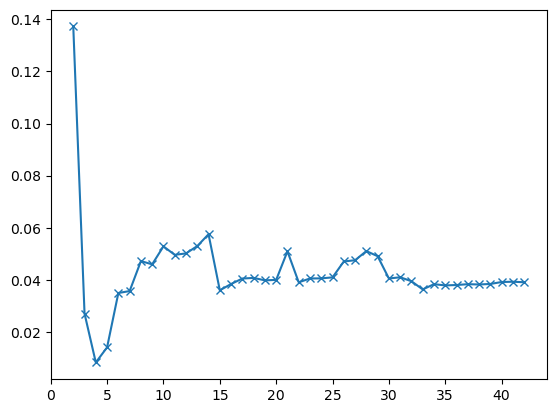

In [41]:
plt.plot(cluster_range, silhouette, marker='x');

Попробуем подобрать кластеры на графике, на 2 лучше показатель

In [42]:
scaler_kmeans = PowerTransformer()
train_data_kmeans = scaler_kmeans.fit_transform(train_gates_in_day_pattern.iloc[:,1:])
test_data_kmeans = scaler_kmeans.transform(test_gates_in_day_pattern.iloc[:,1:])

Странно что выбор минимального значения дает больший скор, хотя в документации написано что нужно выбирать по большему, но возможно зависит от метрики, в данном случае Эвклидово расстояния, по логике должно быть чем меньше тем лучше 

In [43]:
optimal = cluster_range[np.argmin(silhouette)]
optimal

4

In [44]:
kmeans = KMeans(n_clusters=optimal)
train_gates_in_day_pattern['cluster'] = kmeans.fit_predict(train_data_kmeans)
test_gates_in_day_pattern['cluster'] = kmeans.predict(test_data_kmeans)

C:\Users\Developer\anaconda3\envs\shifr_catboost\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Developer\AppData\Local\Temp\ipykernel_10964\1070833421.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_gates_in_day_pattern['cluster'] = kmeans.fit_predict(train_data_kmeans)
C:\Users\Developer\AppData\Local\Temp\ipykernel_10964\1070833421.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_data_kmeans)

Визуализируем по двум компонентам

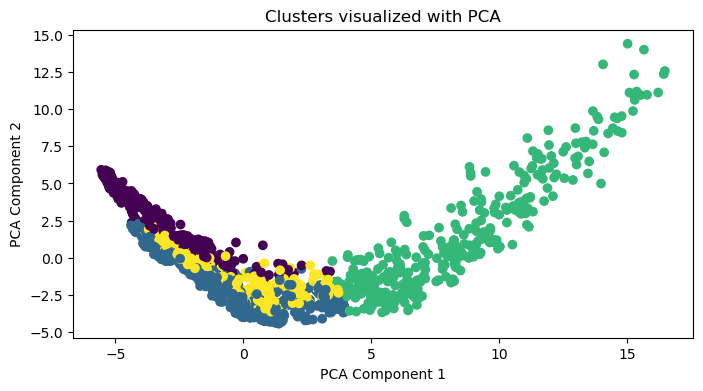

In [46]:
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_gates_in_day_pattern['cluster'], cmap='viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [47]:
train_gates_in_day_pattern.head()

,user_id,is_month_start,is_month_end,is_bussines_day_start,is_bussines_day_end,is_bussines_day,is_weekend,worktime_hour_sin,worktime_hour_cos,worktime_min_sin,worktime_min_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_min_sin,first_enter_min_cos,exit_hour_sin,exit_hour_cos,exit_min_sin,exit_min_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16,gate_17,gate_18,gate_19,enter_to_main_enterance,gates_timing_hours_sin_1,gates_timing_hours_sin_2,gates_timing_hours_sin_3,gates_timing_hours_sin_4,gates_timing_hours_sin_5,gates_timing_hours_sin_6,gates_timing_hours_sin_7,gates_timing_hours_sin_8,gates_timing_hours_sin_9,gates_timing_hours_sin_10,gates_timing_hours_sin_11,gates_timing_hours_sin_12,gates_timing_hours_sin_13,gates_timing_hours_sin_14,gates_timing_hours_sin_15,gates_timing_hours_sin_16,gates_timing_hours_sin_17,gates_timing_hours_sin_18,gates_timing_hours_sin_19,gates_timing_hours_cos_1,gates_timing_hours_cos_2,gates_timing_hours_cos_3,gates_timing_hours_cos_4,gates_timing_hours_cos_5,gates_timing_hours_cos_6,gates_timing_hours_cos_7,gates_timing_hours_cos_8,gates_timing_hours_cos_9,gates_timing_hours_cos_10,gates_timing_hours_cos_11,gates_timing_hours_cos_12,gates_timing_hours_cos_13,gates_timing_hours_cos_14,gates_timing_hours_cos_15,gates_timing_hours_cos_16,gates_timing_hours_cos_17,gates_timing_hours_cos_18,gates_timing_hours_cos_19,gates_timing_minutes_sin_1,gates_timing_minutes_sin_2,gates_timing_minutes_sin_3,gates_timing_minutes_sin_4,gates_timing_minutes_sin_5,gates_timing_minutes_sin_6,gates_timing_minutes_sin_7,gates_timing_minutes_sin_8,gates_timing_minutes_sin_9,gates_timing_minutes_sin_10,gates_timing_minutes_sin_11,gates_timing_minutes_sin_12,gates_timing_minutes_sin_13,gates_timing_minutes_sin_14,gates_timing_minutes_sin_15,gates_timing_minutes_sin_16,gates_timing_minutes_sin_17,gates_timing_minutes_sin_18,gates_timing_minutes_sin_19,gates_timing_minutes_cos_1,gates_timing_minutes_cos_2,gates_timing_minutes_cos_3,gates_timing_minutes_cos_4,gates_timing_minutes_cos_5,gates_timing_minutes_cos_6,gates_timing_minutes_cos_7,gates_timing_minutes_cos_8,gates_timing_minutes_cos_9,gates_timing_minutes_cos_10,gates_timing_minutes_cos_11,gates_timing_minutes_cos_12,gates_timing_minutes_cos_13,gates_timing_minutes_cos_14,gates_timing_minutes_cos_15,gates_timing_minutes_cos_16,gates_timing_minutes_cos_17,gates_timing_minutes_cos_18,gates_timing_minutes_cos_19,gates_timing_seconds_sin_1,gates_timing_seconds_sin_2,gates_timing_seconds_sin_3,gates_timing_seconds_sin_4,gates_timing_seconds_sin_5,gates_timing_seconds_sin_6,gates_timing_seconds_sin_7,gates_timing_seconds_sin_8,gates_timing_seconds_sin_9,gates_timing_seconds_sin_10,gates_timing_seconds_sin_11,gates_timing_seconds_sin_12,gates_timing_seconds_sin_13,gates_timing_seconds_sin_14,gates_timing_seconds_sin_15,gates_timing_seconds_sin_16,gates_timing_seconds_sin_17,gates_timing_seconds_sin_18,gates_timing_seconds_sin_19,gates_timing_seconds_cos_1,gates_timing_seconds_cos_2,gates_timing_seconds_cos_3,gates_timing_seconds_cos_4,gates_timing_seconds_cos_5,gates_timing_seconds_cos_6,gates_timing_seconds_cos_7,gates_timing_seconds_cos_8,gates_timing_seconds_cos_9,gates_timing_seconds_cos_10,gates_timing_seconds_cos_11,gates_timing_seconds_cos_12,gates_timing_seconds_cos_13,gates_timing_seconds_cos_14,gates_timing_seconds_cos_15,gates_timing_seconds_cos_16,gates_timing_seconds_cos_17,gates_timing_seconds_cos_18,gates_timing_seconds_cos_19,cluster
0,0,0,0,0,1,1,0,0.829038,-0.559193,0.994522,-0.104528,0.500000,-0.866025,5.665539e-16,-1.000000,-1.000000,-1.836970e-16,-0.994522,0.104528,-0.394356,0.918958,-8.660254e-01,-0.5,-0.500000,-0.866025,3,11,6,7,3,10,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.000000,0.258819,0.0,0.000000,0.866025,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,1.000000,0.965926,1.0,1.0000

In [48]:
test_gates_in_day_pattern.head()

,lost_id,is_month_start,is_month_end,is_bussines_day_start,is_bussines_day_end,is_bussines_day,is_weekend,worktime_hour_sin,worktime_hour_cos,worktime_min_sin,worktime_min_cos,first_enter_hour_sin,first_enter_hour_cos,first_enter_min_sin,first_enter_min_cos,exit_hour_sin,exit_hour_cos,exit_min_sin,exit_min_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16,gate_17,gate_18,gate_19,enter_to_main_enterance,gates_timing_hours_sin_1,gates_timing_hours_sin_2,gates_timing_hours_sin_3,gates_timing_hours_sin_4,gates_timing_hours_sin_5,gates_timing_hours_sin_6,gates_timing_hours_sin_7,gates_timing_hours_sin_8,gates_timing_hours_sin_9,gates_timing_hours_sin_10,gates_timing_hours_sin_11,gates_timing_hours_sin_12,gates_timing_hours_sin_13,gates_timing_hours_sin_14,gates_timing_hours_sin_15,gates_timing_hours_sin_16,gates_timing_hours_sin_17,gates_timing_hours_sin_18,gates_timing_hours_sin_19,gates_timing_hours_cos_1,gates_timing_hours_cos_2,gates_timing_hours_cos_3,gates_timing_hours_cos_4,gates_timing_hours_cos_5,gates_timing_hours_cos_6,gates_timing_hours_cos_7,gates_timing_hours_cos_8,gates_timing_hours_cos_9,gates_timing_hours_cos_10,gates_timing_hours_cos_11,gates_timing_hours_cos_12,gates_timing_hours_cos_13,gates_timing_hours_cos_14,gates_timing_hours_cos_15,gates_timing_hours_cos_16,gates_timing_hours_cos_17,gates_timing_hours_cos_18,gates_timing_hours_cos_19,gates_timing_minutes_sin_1,gates_timing_minutes_sin_2,gates_timing_minutes_sin_3,gates_timing_minutes_sin_4,gates_timing_minutes_sin_5,gates_timing_minutes_sin_6,gates_timing_minutes_sin_7,gates_timing_minutes_sin_8,gates_timing_minutes_sin_9,gates_timing_minutes_sin_10,gates_timing_minutes_sin_11,gates_timing_minutes_sin_12,gates_timing_minutes_sin_13,gates_timing_minutes_sin_14,gates_timing_minutes_sin_15,gates_timing_minutes_sin_16,gates_timing_minutes_sin_17,gates_timing_minutes_sin_18,gates_timing_minutes_sin_19,gates_timing_minutes_cos_1,gates_timing_minutes_cos_2,gates_timing_minutes_cos_3,gates_timing_minutes_cos_4,gates_timing_minutes_cos_5,gates_timing_minutes_cos_6,gates_timing_minutes_cos_7,gates_timing_minutes_cos_8,gates_timing_minutes_cos_9,gates_timing_minutes_cos_10,gates_timing_minutes_cos_11,gates_timing_minutes_cos_12,gates_timing_minutes_cos_13,gates_timing_minutes_cos_14,gates_timing_minutes_cos_15,gates_timing_minutes_cos_16,gates_timing_minutes_cos_17,gates_timing_minutes_cos_18,gates_timing_minutes_cos_19,gates_timing_seconds_sin_1,gates_timing_seconds_sin_2,gates_timing_seconds_sin_3,gates_timing_seconds_sin_4,gates_timing_seconds_sin_5,gates_timing_seconds_sin_6,gates_timing_seconds_sin_7,gates_timing_seconds_sin_8,gates_timing_seconds_sin_9,gates_timing_seconds_sin_10,gates_timing_seconds_sin_11,gates_timing_seconds_sin_12,gates_timing_seconds_sin_13,gates_timing_seconds_sin_14,gates_timing_seconds_sin_15,gates_timing_seconds_sin_16,gates_timing_seconds_sin_17,gates_timing_seconds_sin_18,gates_timing_seconds_sin_19,gates_timing_seconds_cos_1,gates_timing_seconds_cos_2,gates_timing_seconds_cos_3,gates_timing_seconds_cos_4,gates_timing_seconds_cos_5,gates_timing_seconds_cos_6,gates_timing_seconds_cos_7,gates_timing_seconds_cos_8,gates_timing_seconds_cos_9,gates_timing_seconds_cos_10,gates_timing_seconds_cos_11,gates_timing_seconds_cos_12,gates_timing_seconds_cos_13,gates_timing_seconds_cos_14,gates_timing_seconds_cos_15,gates_timing_seconds_cos_16,gates_timing_seconds_cos_17,gates_timing_seconds_cos_18,gates_timing_seconds_cos_19,cluster
0,0,0,0,0,0,1,0,0.998712,-0.050738,0.938493,0.345298,-0.258819,-0.965926,-0.951057,-3.090170e-01,-0.965926,0.258819,-6.691306e-01,0.743145,0.571268,0.820763,8.660254e-01,0.5,0.5,0.866025,3,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.123234e-17,1.0,0.000000,0.0,0.000000,0.000000,0.0000

In [49]:
train = train_gates_in_day_pattern.copy()
test = test_gates_in_day_pattern.copy() 

In [50]:
def get_padded_dummies(df, col, rs, re):
    uniques = sorted(list(df[col].unique()))
    df = pd.get_dummies(df, columns=[col], dtype='int8')
    list_vars = [col+'_' + str(i) for i in (set(range(rs, re)) - set(uniques))]
    if len(list_vars) != 0:
        df[list_vars] = 0
    return df

Превратим кластеры в фиктивные переменные

In [51]:
y = train['user_id'].astype(int)
train.drop(columns=['user_id'], inplace=True)
train = get_padded_dummies(train, 'cluster', 0, kmeans.n_clusters)
train.drop('cluster_0', axis=1, inplace=True)
train.sort_index(axis=1, inplace=True)
test = get_padded_dummies(test, 'cluster', 0, kmeans.n_clusters)
test = test[train.columns]

In [52]:
train.columns

Index(['cluster_1', 'cluster_2', 'cluster_3', 'day_cos', 'day_sin',
       'dayofweek_cos', 'dayofweek_sin', 'enter_to_main_enterance',
       'exit_hour_cos', 'exit_hour_sin',
       ...
       'is_bussines_day_start', 'is_month_end', 'is_month_start', 'is_weekend',
       'month_cos', 'month_sin', 'worktime_hour_cos', 'worktime_hour_sin',
       'worktime_min_cos', 'worktime_min_sin'],
      dtype='object', length=162)

In [53]:
test.columns

Index(['cluster_1', 'cluster_2', 'cluster_3', 'day_cos', 'day_sin',
       'dayofweek_cos', 'dayofweek_sin', 'enter_to_main_enterance',
       'exit_hour_cos', 'exit_hour_sin',
       ...
       'is_bussines_day_start', 'is_month_end', 'is_month_start', 'is_weekend',
       'month_cos', 'month_sin', 'worktime_hour_cos', 'worktime_hour_sin',
       'worktime_min_cos', 'worktime_min_sin'],
      dtype='object', length=162)

In [54]:
train.head()

,cluster_1,cluster_2,cluster_3,day_cos,day_sin,dayofweek_cos,dayofweek_sin,enter_to_main_enterance,exit_hour_cos,exit_hour_sin,exit_min_cos,exit_min_sin,first_enter_hour_cos,first_enter_hour_sin,first_enter_min_cos,first_enter_min_sin,gate_0,gate_1,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16,gate_17,gate_18,gate_19,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,gates_timing_hours_cos_1,gates_timing_hours_cos_10,gates_timing_hours_cos_11,gates_timing_hours_cos_12,gates_timing_hours_cos_13,gates_timing_hours_cos_14,gates_timing_hours_cos_15,gates_timing_hours_cos_16,gates_timing_hours_cos_17,gates_timing_hours_cos_18,gates_timing_hours_cos_19,gates_timing_hours_cos_2,gates_timing_hours_cos_3,gates_timing_hours_cos_4,gates_timing_hours_cos_5,gates_timing_hours_cos_6,gates_timing_hours_cos_7,gates_timing_hours_cos_8,gates_timing_hours_cos_9,gates_timing_hours_sin_1,gates_timing_hours_sin_10,gates_timing_hours_sin_11,gates_timing_hours_sin_12,gates_timing_hours_sin_13,gates_timing_hours_sin_14,gates_timing_hours_sin_15,gates_timing_hours_sin_16,gates_timing_hours_sin_17,gates_timing_hours_sin_18,gates_timing_hours_sin_19,gates_timing_hours_sin_2,gates_timing_hours_sin_3,gates_timing_hours_sin_4,gates_timing_hours_sin_5,gates_timing_hours_sin_6,gates_timing_hours_sin_7,gates_timing_hours_sin_8,gates_timing_hours_sin_9,gates_timing_minutes_cos_1,gates_timing_minutes_cos_10,gates_timing_minutes_cos_11,gates_timing_minutes_cos_12,gates_timing_minutes_cos_13,gates_timing_minutes_cos_14,gates_timing_minutes_cos_15,gates_timing_minutes_cos_16,gates_timing_minutes_cos_17,gates_timing_minutes_cos_18,gates_timing_minutes_cos_19,gates_timing_minutes_cos_2,gates_timing_minutes_cos_3,gates_timing_minutes_cos_4,gates_timing_minutes_cos_5,gates_timing_minutes_cos_6,gates_timing_minutes_cos_7,gates_timing_minutes_cos_8,gates_timing_minutes_cos_9,gates_timing_minutes_sin_1,gates_timing_minutes_sin_10,gates_timing_minutes_sin_11,gates_timing_minutes_sin_12,gates_timing_minutes_sin_13,gates_timing_minutes_sin_14,gates_timing_minutes_sin_15,gates_timing_minutes_sin_16,gates_timing_minutes_sin_17,gates_timing_minutes_sin_18,gates_timing_minutes_sin_19,gates_timing_minutes_sin_2,gates_timing_minutes_sin_3,gates_timing_minutes_sin_4,gates_timing_minutes_sin_5,gates_timing_minutes_sin_6,gates_timing_minutes_sin_7,gates_timing_minutes_sin_8,gates_timing_minutes_sin_9,gates_timing_seconds_cos_1,gates_timing_seconds_cos_10,gates_timing_seconds_cos_11,gates_timing_seconds_cos_12,gates_timing_seconds_cos_13,gates_timing_seconds_cos_14,gates_timing_seconds_cos_15,gates_timing_seconds_cos_16,gates_timing_seconds_cos_17,gates_timing_seconds_cos_18,gates_timing_seconds_cos_19,gates_timing_seconds_cos_2,gates_timing_seconds_cos_3,gates_timing_seconds_cos_4,gates_timing_seconds_cos_5,gates_timing_seconds_cos_6,gates_timing_seconds_cos_7,gates_timing_seconds_cos_8,gates_timing_seconds_cos_9,gates_timing_seconds_sin_1,gates_timing_seconds_sin_10,gates_timing_seconds_sin_11,gates_timing_seconds_sin_12,gates_timing_seconds_sin_13,gates_timing_seconds_sin_14,gates_timing_seconds_sin_15,gates_timing_seconds_sin_16,gates_timing_seconds_sin_17,gates_timing_seconds_sin_18,gates_timing_seconds_sin_19,gates_timing_seconds_sin_2,gates_timing_seconds_sin_3,gates_timing_seconds_sin_4,gates_timing_seconds_sin_5,gates_timing_seconds_sin_6,gates_timing_seconds_sin_7,gates_timing_seconds_sin_8,gates_timing_seconds_sin_9,is_bussines_day,is_bussines_day_end,is_bussines_day_start,is_month_end,is_month_start,is_weekend,month_cos,month_sin,worktime_hour_cos,worktime_hour_sin,worktime_min_cos,worktime_min_sin
0,0,0,0,0.918958,-0.394356,-0.5,-8.660254e-01,0,-1.836970e-16,-1.000000,0.104528,-0.994522,-0.866025,0.500000,-1.000000,5.665539e-16,3,11,0,0,0,0,0,0,0,0,0,0,6,7,3,10,11,4,0,0,0.866025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.965926,1.0,1.000000,0.5,1.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.258819,0.0,0.000000,0.866025,0.000

Получим тестовую и валидационную выборку

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2) 

Пройдемся трансформером, скаллер давал меньше скор

In [56]:
# Сделаем нормирование отдельными скейлерами по X и по X_val, т.к. будущие данные скорее всего изменятся

scaler_X = PowerTransformer().set_output(transform="pandas")
scaler_X_val = PowerTransformer().set_output(transform="pandas")

X_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X_val.fit_transform(X_test)

In [57]:
print('Признаки, всего', len(train.columns))
print(list(train.columns))

Признаки, всего 162
['cluster_1', 'cluster_2', 'cluster_3', 'day_cos', 'day_sin', 'dayofweek_cos', 'dayofweek_sin', 'enter_to_main_enterance', 'exit_hour_cos', 'exit_hour_sin', 'exit_min_cos', 'exit_min_sin', 'first_enter_hour_cos', 'first_enter_hour_sin', 'first_enter_min_cos', 'first_enter_min_sin', 'gate_0', 'gate_1', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14', 'gate_15', 'gate_16', 'gate_17', 'gate_18', 'gate_19', 'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gates_timing_hours_cos_1', 'gates_timing_hours_cos_10', 'gates_timing_hours_cos_11', 'gates_timing_hours_cos_12', 'gates_timing_hours_cos_13', 'gates_timing_hours_cos_14', 'gates_timing_hours_cos_15', 'gates_timing_hours_cos_16', 'gates_timing_hours_cos_17', 'gates_timing_hours_cos_18', 'gates_timing_hours_cos_19', 'gates_timing_hours_cos_2', 'gates_timing_hours_cos_3', 'gates_timing_hours_cos_4', 'gates_timing_hours_cos_5', 'gates_timing_hours_cos_6', 'gates_timing_hours_cos_7', '

In [58]:
X_scaled

,cluster_1,cluster_2,cluster_3,day_cos,day_sin,dayofweek_cos,dayofweek_sin,enter_to_main_enterance,exit_hour_cos,exit_hour_sin,exit_min_cos,exit_min_sin,first_enter_hour_cos,first_enter_hour_sin,first_enter_min_cos,first_enter_min_sin,gate_0,gate_1,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16,gate_17,gate_18,gate_19,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,gates_timing_hours_cos_1,gates_timing_hours_cos_10,gates_timing_hours_cos_11,gates_timing_hours_cos_12,gates_timing_hours_cos_13,gates_timing_hours_cos_14,gates_timing_hours_cos_15,gates_timing_hours_cos_16,gates_timing_hours_cos_17,gates_timing_hours_cos_18,gates_timing_hours_cos_19,gates_timing_hours_cos_2,gates_timing_hours_cos_3,gates_timing_hours_cos_4,gates_timing_hours_cos_5,gates_timing_hours_cos_6,gates_timing_hours_cos_7,gates_timing_hours_cos_8,gates_timing_hours_cos_9,gates_timing_hours_sin_1,gates_timing_hours_sin_10,gates_timing_hours_sin_11,gates_timing_hours_sin_12,gates_timing_hours_sin_13,gates_timing_hours_sin_14,gates_timing_hours_sin_15,gates_timing_hours_sin_16,gates_timing_hours_sin_17,gates_timing_hours_sin_18,gates_timing_hours_sin_19,gates_timing_hours_sin_2,gates_timing_hours_sin_3,gates_timing_hours_sin_4,gates_timing_hours_sin_5,gates_timing_hours_sin_6,gates_timing_hours_sin_7,gates_timing_hours_sin_8,gates_timing_hours_sin_9,gates_timing_minutes_cos_1,gates_timing_minutes_cos_10,gates_timing_minutes_cos_11,gates_timing_minutes_cos_12,gates_timing_minutes_cos_13,gates_timing_minutes_cos_14,gates_timing_minutes_cos_15,gates_timing_minutes_cos_16,gates_timing_minutes_cos_17,gates_timing_minutes_cos_18,gates_timing_minutes_cos_19,gates_timing_minutes_cos_2,gates_timing_minutes_cos_3,gates_timing_minutes_cos_4,gates_timing_minutes_cos_5,gates_timing_minutes_cos_6,gates_timing_minutes_cos_7,gates_timing_minutes_cos_8,gates_timing_minutes_cos_9,gates_timing_minutes_sin_1,gates_timing_minutes_sin_10,gates_timing_minutes_sin_11,gates_timing_minutes_sin_12,gates_timing_minutes_sin_13,gates_timing_minutes_sin_14,gates_timing_minutes_sin_15,gates_timing_minutes_sin_16,gates_timing_minutes_sin_17,gates_timing_minutes_sin_18,gates_timing_minutes_sin_19,gates_timing_minutes_sin_2,gates_timing_minutes_sin_3,gates_timing_minutes_sin_4,gates_timing_minutes_sin_5,gates_timing_minutes_sin_6,gates_timing_minutes_sin_7,gates_timing_minutes_sin_8,gates_timing_minutes_sin_9,gates_timing_seconds_cos_1,gates_timing_seconds_cos_10,gates_timing_seconds_cos_11,gates_timing_seconds_cos_12,gates_timing_seconds_cos_13,gates_timing_seconds_cos_14,gates_timing_seconds_cos_15,gates_timing_seconds_cos_16,gates_timing_seconds_cos_17,gates_timing_seconds_cos_18,gates_timing_seconds_cos_19,gates_timing_seconds_cos_2,gates_timing_seconds_cos_3,gates_timing_seconds_cos_4,gates_timing_seconds_cos_5,gates_timing_seconds_cos_6,gates_timing_seconds_cos_7,gates_timing_seconds_cos_8,gates_timing_seconds_cos_9,gates_timing_seconds_sin_1,gates_timing_seconds_sin_10,gates_timing_seconds_sin_11,gates_timing_seconds_sin_12,gates_timing_seconds_sin_13,gates_timing_seconds_sin_14,gates_timing_seconds_sin_15,gates_timing_seconds_sin_16,gates_timing_seconds_sin_17,gates_timing_seconds_sin_18,gates_timing_seconds_sin_19,gates_timing_seconds_sin_2,gates_timing_seconds_sin_3,gates_timing_seconds_sin_4,gates_timing_seconds_sin_5,gates_timing_seconds_sin_6,gates_timing_seconds_sin_7,gates_timing_seconds_sin_8,gates_timing_seconds_sin_9,is_bussines_day,is_bussines_day_end,is_bussines_day_start,is_month_end,is_month_start,is_weekend,month_cos,month_sin,worktime_hour_cos,worktime_hour_sin,worktime_min_cos,worktime_min_sin
289,-0.842517,2.276642,-0.593135,1.352262,0.376085,1.409196,-0.298718,-1.609659,-0.444230,-1.030195,-0.693197,1.206932,1.051462,1.187641,-1.282040,-0.682702,0.920855,-0.249158,1.146201,1.772199,2.000942,2.278378,2.575809,3.237117,3.760058,4.638192,5.724442,8.680313,1.121730,-1.562092,0.166514,-0.456349,1.074705,1.130842,0.436423,1.134012,0.223123,1.424323,1.714440

Попробуем уменьшить размерность с помошью PCA

In [59]:
pca_cutoff = PCA().set_output(transform="pandas")
pca_cutoff.fit(X_scaled);

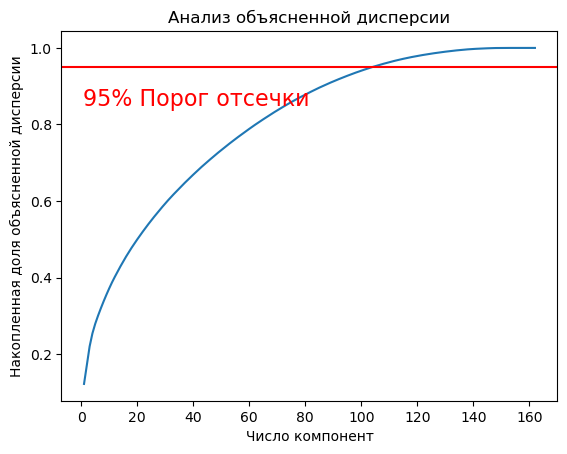

In [60]:
explained_variance_ratio = pca_cutoff.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Визуализация объясненной дисперсии
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.text(0.5, 0.85, '95% Порог отсечки', color = 'red', fontsize=16)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xticks(np.arange(0, len(X_scaled.columns), step=20))
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля объясненной дисперсии")
plt.title("Анализ объясненной дисперсии")
plt.show()

In [61]:
pca = PCA(n_components=0.95).set_output(transform="pandas")

pca.fit(X_scaled)

X_scaled_pca = pca.transform(X_scaled)
X_val_scaled_pca = pca.transform(X_val_scaled)

In [62]:
y_train

289      6
1268    33
1062    26
1926    50
1808    49
        ..
146      1
2171    55
565     12
901     19
1495    37
Name: user_id, Length: 1756, dtype: int32

# Обучение и предсказание

Обучим на фичах RandomForestClassifier и CatBoostClassifier

In [63]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=200, bootstrap=True, criterion='gini', max_depth=30, random_state=17)

model.fit(X_scaled, y_train)
y_pred = model.predict(X_scaled)

y_val_pred = model.predict(X_val_scaled)
print(accuracy_score(y_test, y_val_pred))
print(f"F1-мера: {f1_score(y_test, y_val_pred,  average='weighted')}")

0.4954545454545455
F1-мера: 0.47317121849633037


RandomForestClassifier работает чутка хуже

In [64]:
train_pool = Pool(data=X_scaled, label=y_train, has_header=True)

depth = 5
iterations = 1000

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(iterations=iterations, learning_rate=0.1, loss_function='MultiClass', depth=depth, task_type = 'GPU', 
                           bagging_temperature = 1, metric_period=100, class_weights=class_weights)

model.fit(train_pool)
y_pred = model.predict(X_scaled)

y_val_pred = model.predict(X_val_scaled)
print(accuracy_score(y_test, y_val_pred))
print(f"F1-мера: {f1_score(y_test, y_val_pred,  average='weighted')}")

0:	learn: 3.5552887	total: 122ms	remaining: 2m 1s
100:	learn: 1.0881477	total: 1.82s	remaining: 16.2s
200:	learn: 0.7610797	total: 3.63s	remaining: 14.4s
300:	learn: 0.5806810	total: 5.01s	remaining: 11.6s
400:	learn: 0.4733518	total: 6.08s	remaining: 9.08s
500:	learn: 0.4037190	total: 7.11s	remaining: 7.08s
600:	learn: 0.3498484	total: 8.18s	remaining: 5.43s
700:	learn: 0.3068584	total: 9.2s	remaining: 3.92s
800:	learn: 0.2735647	total: 10.2s	remaining: 2.54s
900:	learn: 0.2461503	total: 11.3s	remaining: 1.24s
999:	learn: 0.2229638	total: 12.3s	remaining: 0us
0.5022727272727273
F1-мера: 0.5000956490799472


Посмотри что у нас с PCA, результат почему-то хуже

In [65]:
train_pool = Pool(data=X_scaled_pca, label=y_train, has_header=True)
model_pca = CatBoostClassifier(iterations=600, learning_rate=0.1, loss_function='MultiClass', depth=4, task_type = 'GPU', 
                           metric_period=100)

model_pca.fit(train_pool)
y_pred_pca = model_pca.predict(X_scaled_pca)

y_val_pred_pca = model_pca.predict(X_val_scaled_pca)
print(accuracy_score(y_test, y_val_pred_pca))
print(f"F1-мера: {f1_score(y_test, y_val_pred_pca,  average='weighted')}")

0:	learn: 3.6177506	total: 7.72ms	remaining: 4.62s
100:	learn: 1.7368982	total: 783ms	remaining: 3.87s
200:	learn: 1.1446025	total: 1.58s	remaining: 3.13s
300:	learn: 0.7727640	total: 2.34s	remaining: 2.33s
400:	learn: 0.5464097	total: 3.09s	remaining: 1.53s
500:	learn: 0.4035309	total: 3.83s	remaining: 757ms
599:	learn: 0.3137871	total: 4.61s	remaining: 0us
0.3409090909090909
F1-мера: 0.3253495941204169


Можно посмотреть кросс-валидацию

In [66]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': iterations,
    'learning_rate': 0.1,
    'depth': depth,
    'task_type': 'GPU',
    'bagging_temperature': 1
}

def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-MultiClass-mean'].min()
    best_iter = cv_data['test-MultiClass-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-MultiClass-mean'][best_iter],
        best_iter)
    )
    return best_iter

def cross_val():
    val_pool = Pool(data=X_val_scaled, label=y_test, has_header=True)

    cv_data = cv(
        params = params,
        pool = val_pool,
        fold_count=10,
        shuffle=True,
        partition_random_seed=17,
        plot=True,
        stratified=False,
        verbose=False
    )

    return print_cv_summary(cv_data)

best = cross_val()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
bestTest = 2.481749795
bestIteration = 695
Training on fold [1/10]
bestTest = 2.438055212
bestIteration = 983
Training on fold [2/10]
bestTest = 2.139595725
bestIteration = 913
Training on fold [3/10]
bestTest = 2.637731899
bestIteration = 255
Training on fold [4/10]
bestTest = 2.258595207
bestIteration = 446
Training on fold [5/10]
bestTest = 2.331103932
bestIteration = 411
Training on fold [6/10]
bestTest = 2.165353428
bestIteration = 941
Training on fold [7/10]
bestTest = 2.649541681
bestIteration = 327
Training on fold [8/10]
bestTest = 2.315722899
bestIteration = 873
Training on fold [9/10]
bestTest = 2.350235332
bestIteration = 823
Best validation Logloss score : 2.3904±2.3904 on step 806


Посмотрим важность фич

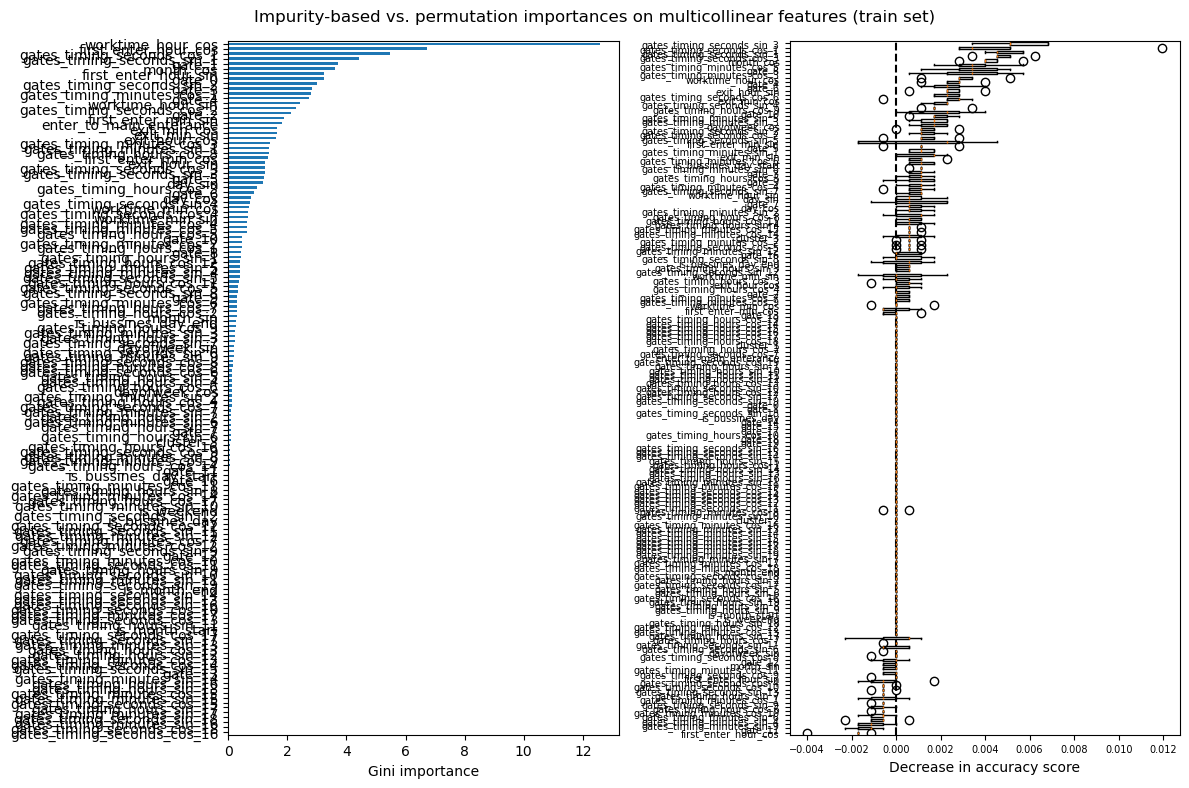

In [67]:
show_importances = True

def plot_permutation_importance(model, X, y, ax):
    result = permutation_importance(model, X, y, n_repeats=5, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()
    tick_labels_parameter_name = (
        "tick_labels"
    )
    tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

if show_importances:
    mdi_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    mdi_importances = mdi_importances[mdi_importances > 0.0] # чтобы влезло
    tree_importance_sorted_idx = np.argsort(model.feature_importances_)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    plt.tick_params(labelsize=7)
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(model, X_train, y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importances on multicollinear features (train set)"
    )
    _ = fig.tight_layout()

Удалим колонки с малой важностью

In [68]:
mdi_importances = pd.Series(model.feature_importances_, index=X_train.columns)
mdi_importances

cluster_1             0.000000
cluster_2             0.000000
cluster_3             0.085161
day_cos               0.757996
day_sin               1.162043
                       ...    
month_sin             0.282796
worktime_hour_cos    12.581351
worktime_hour_sin     2.422192
worktime_min_cos      0.687984
worktime_min_sin      0.664595
Length: 162, dtype: float64

In [69]:
mdi_importances = mdi_importances[mdi_importances != 0.0]
mdi_importances

cluster_3             0.085161
day_cos               0.757996
day_sin               1.162043
dayofweek_cos         0.124669
dayofweek_sin         0.211449
                       ...    
month_sin             0.282796
worktime_hour_cos    12.581351
worktime_hour_sin     2.422192
worktime_min_cos      0.687984
worktime_min_sin      0.664595
Length: 140, dtype: float64

Перезапустим с обрезаными фичами

In [70]:
train_pool = Pool(data=X_scaled[mdi_importances.index], label=y_train, has_header=True)

model_imp = CatBoostClassifier(iterations=best, learning_rate=0.1, loss_function='MultiClass', 
                               depth=depth, task_type = 'GPU', bagging_temperature = 1, metric_period=100, class_weights=class_weights)

model_imp.fit(train_pool)
y_pred = model_imp.predict(X_scaled[mdi_importances.index])

y_val_pred = model_imp.predict(X_val_scaled[mdi_importances.index])
print(accuracy_score(y_test, y_val_pred))
print(f"F1-мера: {f1_score(y_test, y_val_pred,  average='weighted')}")

0:	learn: 3.5552890	total: 9.65ms	remaining: 7.77s
100:	learn: 1.0881476	total: 1.05s	remaining: 7.35s
200:	learn: 0.7610797	total: 2.07s	remaining: 6.23s
300:	learn: 0.5806809	total: 3.15s	remaining: 5.29s
400:	learn: 0.4733518	total: 4.23s	remaining: 4.27s
500:	learn: 0.4037190	total: 5.29s	remaining: 3.22s
600:	learn: 0.3498484	total: 6.34s	remaining: 2.16s
700:	learn: 0.3068584	total: 7.41s	remaining: 1.11s
800:	learn: 0.2735648	total: 8.45s	remaining: 52.7ms
805:	learn: 0.2716936	total: 8.5s	remaining: 0us
0.5136363636363637
F1-мера: 0.5111115713447179


Подберем лучшее кол-во шагов 

In [ ]:
best = cross_val()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
bestTest = 2.481749795
bestIteration = 695
Training on fold [1/10]
bestTest = 2.438055212
bestIteration = 983
Training on fold [2/10]
bestTest = 2.139595725
bestIteration = 913
Training on fold [3/10]
bestTest = 2.637731899
bestIteration = 255
Training on fold [4/10]
bestTest = 2.258595207
bestIteration = 446
Training on fold [5/10]


Прогоним еще раз

In [ ]:
train_pool = Pool(data=X_scaled[mdi_importances.index], label=y_train, has_header=True)

model_imp = CatBoostClassifier(iterations=best, learning_rate=0.1, loss_function='MultiClass', 
                               depth=depth, task_type = 'GPU', bagging_temperature = 1, metric_period=100, class_weights=class_weights)

model_imp.fit(train_pool)
y_pred = model_imp.predict(X_scaled[mdi_importances.index])

y_val_pred = model_imp.predict(X_val_scaled[mdi_importances.index])
print(accuracy_score(y_test, y_val_pred))
print(f"F1-мера: {f1_score(y_test, y_val_pred,  average='weighted')}")

Если убрать с нулевой важностью можно улучшить скор

In [ ]:
X_scaled[mdi_importances.index]

# Выводы

Получилось неидеально. Были найдены особенности во временных паттернах, очищены и преобразованы данные с последующим их обогащением, скор получился чутка лучше чем хомяк в колесе торгующий криптой. Классы оказались не сбалансированный, но времени не хватило на их балансировку и генерацию "Похожих" признаков для балансировки. Неиспробован бутстрап.

# Подготовка для отправки

In [ ]:
results = pd.DataFrame(y_test)
results['pred'] = y_val_pred
results

In [ ]:
results['user_id'].unique().shape

Моды для теста и для релиза, если "мало" мод то скорее всего это новый сотрудник

In [ ]:
def mode_1(x):
    return x.mode().iloc[0]

In [ ]:
# Предскажем самым частотным user_id на val
res = results.groupby('user_id')['pred'].agg([mode_1, 'count']) 
display(res)

Изучим среднее и медиану по скорам, установил порог ниже чтобы отсекал возможных новых

In [ ]:
res['count'].agg({'mean', 'median'})

In [ ]:
res = res.reset_index(); 
del res['count']

In [ ]:
print('correct', (res['user_id'] == res['mode_1']).sum())
print('out of', res.shape[0])
print('or', int((res['user_id'] == res['mode_1']).sum()*100 / res.shape[0]), '%')

In [ ]:
# Train предсказуемо имеет более высокую метрику

results2 = pd.DataFrame(y_train)
results2['pred'] = y_pred
res2 = results2.groupby('user_id')['pred'].agg([mode_1]).reset_index()

print('correct', (res2['user_id'] == res2['mode_1']).sum())
print('out of', res2.shape[0])
print('or', int((res2['user_id'] == res2['mode_1']).sum()*100 / res2.shape[0]), '%')

In [ ]:
test_X_scaled = scaler_X.fit_transform(test)
y_test_pred = model_imp.predict(test_X_scaled)

In [ ]:
answer = pd.DataFrame()

answer['lost_id'] = test_gates_in_day_pattern['lost_id']
answer['preds'] = y_test_pred

In [ ]:
answer

In [ ]:
def mode_treshold(x):
    return x.mode().iloc[0] if len(x) > 10 else -999

In [ ]:
# Предскажем самым частотным user_id
submit = pd.DataFrame(answer.groupby('lost_id')['preds'].agg([mode_treshold]))

In [ ]:
submit.index = submit.index.astype(int)
submit.rename(columns={'mode_treshold':'preds'}, inplace=True)
submit

In [ ]:
submit.shape[0]

In [ ]:
submit.to_csv('answer.zip', compression={'method': 'zip', 'archive_name': 'answer.csv'})